# Capstone Proposal: Predicting Developer Salaries from Stack Overflow Survey Data

## 💼 Business Understanding

### Project Goal
The goal of this project is to build a machine learning model that accurately predicts developer annual salary based on various demographic, professional, and technical background features. We use Stack Overflow’s Annual Developer Surveys (2023 and 2024) to train and evaluate our model.

### Why This Topic?
Salary transparency is still limited in many parts of the world, including Kenya. Developers often lack access to reliable salary benchmarks when considering job offers, negotiating promotions, or transitioning into new roles or tech stacks. This model aims to provide data-driven insights that help both job seekers and hiring managers make informed compensation decisions.

### Industry Domain
This project falls under the **Technology** and **Human Capital Analytics** domains. It is especially relevant to the tech industry, as well as HR tech platforms.

### Stakeholders
- **Developers and tech talent**: to benchmark expected compensation
- **Employers and recruiters**: to offer competitive, market-aligned salaries
- **HR tech startups and job boards**: to integrate salary prediction engines
- **Policy & advocacy groups**: for labor market analysis and tech workforce planning
- **Career changers and bootcamps**: to help learners understand ROI on upskilling

### Real-World Impact
If put into production, this model could reduce information asymmetry in tech hiring, promote pay equity, and empower African developers with globally informed compensation insights. In the Kenyan market, where tech hubs are growing and the global talent market is more accessible than ever, such a tool could:
- Help junior/mid-level devs benchmark realistic earnings
- Support remote hiring by showing global salary ranges
- Be adapted for localized platforms like Fuzu, BrighterMonday, or Andela

### Supporting Work
This project builds on several existing works including:
- The [Stack Overflow Developer Salary Calculator](https://stackoverflow.com/salary) - no longer available
- Research on salary modeling using machine learning (e.g., XGBoost, Random Forest)
- Global surveys by GitHub, Dev.to, and PayScale

Our unique contribution is combining recent multi-year survey data and modeling with a lens toward **adaptation for the East African market**.



## 📊🔍 Data Understanding

### Data Sources
We use the publicly available **Stack Overflow Annual Developer Surveys** for:
- 2023: [survey_results_public_2023.csv](#)
- 2024: [survey_results_public_2024.csv](#)

Each dataset contains responses from over 85,000 developers worldwide, with rich information on:
- Demographics (age, gender, country)
- Professional background (years of experience, education, employment type)
- Technical profile (languages, tools, platforms)
- Salary information (`ConvertedCompYearly` in USD)

### Relevance of Data
These surveys provide globally recognized, developer-centric compensation data, with strong coverage across geographies. While there are limited Kenyan responses, the global features can inform localized models, particularly when combined with insights from Nairobi-based developer hubs and local salary platforms (e.g., Glassdoor KE or Safaricom tech job postings).

### Key Variables
We focus on features most likely to influence salary, including:
- `Country`, `YearsCodePro`, `EdLevel`, `Employment`, `DevType`
- Technical tools/languages used
- Remote work status
- Survey year (2023 or 2024)

### Dataset Size
- 2023 survey: ~89,000 responses
- 2024 survey: ~65,000 responses
After cleaning and combining, we expect 100,000+ usable records.

### Missing Data & Limitations
- Some features are specific to one year 
- Salary values may be skewed or self-reported inconsistently
- Country-wise salary distribution is imbalanced (e.g., lots of US data)
- Kenyan representation is low — may need to segment or enrich later

We plan to:
- Focus on common columns across both years
- Drop irrelevant or sparsely populated columns
- Add a `SurveyYear` feature to capture year-based differences
- Possibly filter a subset for Kenya or Africa as a stretch goal



In [75]:
# Import relevant libraries
# warnings
import warnings
warnings.filterwarnings('ignore')
# data handling
import pandas as pd 
import numpy as np
# visualisation
import matplotlib.pyplot as plt
import seaborn as sns
# preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
# models
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
# evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# explainability
import shap
# utilities
import os
from pathlib import Path
# feature selection and importance
from sklearn.feature_selection import SelectKBest, f_regression

In [76]:
# loading the 2023 and 2024 datasets
df_2023 = pd.read_csv('survey_results_public_2023.csv')
df_2024 = pd.read_csv('survey_results_public_2024.csv')

print(df_2023.columns.difference(df_2024.columns))
print(df_2024.columns.difference(df_2023.columns))

Index(['AIDevHaveWorkedWith', 'AIDevWantToWorkWith',
       'AINextNeither different nor similar', 'AINextSomewhat different',
       'AINextSomewhat similar', 'AINextVery different', 'AINextVery similar',
       'AISearchHaveWorkedWith', 'AISearchWantToWorkWith',
       'LearnCodeCoursesCert', 'Q120', 'SOAI', 'TechList'],
      dtype='object')
Index(['AIChallenges', 'AIComplex', 'AIEthics', 'AINextLess integrated',
       'AINextMore integrated', 'AINextMuch less integrated',
       'AINextMuch more integrated', 'AINextNo change', 'AISearchDevAdmired',
       'AISearchDevHaveWorkedWith', 'AISearchDevWantToWorkWith', 'AIThreat',
       'BuildvsBuy', 'Check', 'DatabaseAdmired', 'EmbeddedAdmired',
       'EmbeddedHaveWorkedWith', 'EmbeddedWantToWorkWith', 'Frustration',
       'JobSat', 'JobSatPoints_1', 'JobSatPoints_10', 'JobSatPoints_11',
       'JobSatPoints_4', 'JobSatPoints_5', 'JobSatPoints_6', 'JobSatPoints_7',
       'JobSatPoints_8', 'JobSatPoints_9', 'Knowledge_9', 'LanguageAd

In [77]:
df_2023.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89184 entries, 0 to 89183
Data columns (total 84 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   ResponseId                           89184 non-null  int64  
 1   Q120                                 89184 non-null  object 
 2   MainBranch                           89184 non-null  object 
 3   Age                                  89184 non-null  object 
 4   Employment                           87898 non-null  object 
 5   RemoteWork                           73810 non-null  object 
 6   CodingActivities                     73764 non-null  object 
 7   EdLevel                              87973 non-null  object 
 8   LearnCode                            87663 non-null  object 
 9   LearnCodeOnline                      70084 non-null  object 
 10  LearnCodeCoursesCert                 37076 non-null  object 
 11  YearsCode                   

In [78]:
df_2024.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65437 entries, 0 to 65436
Columns: 114 entries, ResponseId to JobSat
dtypes: float64(13), int64(1), object(100)
memory usage: 56.9+ MB


## Data Cleaning and Feature Engineering 

### A lign columns and merge

In [79]:
# Add SurveyYear column to distinguish entries
df_2023['SurveyYear'] = 2023
df_2024['SurveyYear'] = 2024

# Align column structure by filling in missing columns in each dataset
missing_2023 = df_2024.columns.difference(df_2023.columns)
missing_2024 = df_2023.columns.difference(df_2024.columns)

# Add missing columns to each dataframe and fill with NaN
for col in missing_2023:
    df_2023[col] = np.nan

for col in missing_2024:
    df_2024[col] = np.nan

# Reorder columns to match (important for concat)
df_2023 = df_2023[df_2024.columns]

# Now safely concatenate
df_all = pd.concat([df_2023, df_2024], ignore_index=True)

print(f"Merged shape: {df_all.shape}")


Merged shape: (154621, 128)


### Select Relevant Features

In [80]:
# Focus only on relevant features
selected = [
    'Age', 'Country', 'Employment', 'RemoteWork', 'OrgSize', 'ICorPM',
    'YearsCodePro', 'DevType', 'EdLevel', 'Industry', 
    'PurchaseInfluence', 'BuyNewTool',
    'LanguageHaveWorkedWith', 'PlatformHaveWorkedWith', 'ToolsTechHaveWorkedWith',
    'ConvertedCompYearly', 'SurveyYear', 'AIThreat'
]

df = df_all[selected].copy()

In [81]:
# Drop missing target
df = df[df['ConvertedCompYearly'].notna()]
df = df[df['ConvertedCompYearly'] > 1000]  # Remove unrealistically low salaries


In [82]:
# Fill missing categorical with 'Missing'
categoricals = df.select_dtypes(include='object').columns
df[categoricals] = df[categoricals].fillna('Missing')

In [83]:
# Clean numeric column
df['YearsCodePro'] = pd.to_numeric(df['YearsCodePro'], errors='coerce')
df['YearsCodePro'] = df['YearsCodePro'].fillna(df['YearsCodePro'].median())

print("Final shape after cleaning:", df.shape)

Final shape after cleaning: (70215, 18)


## Exploratory Data Analysis

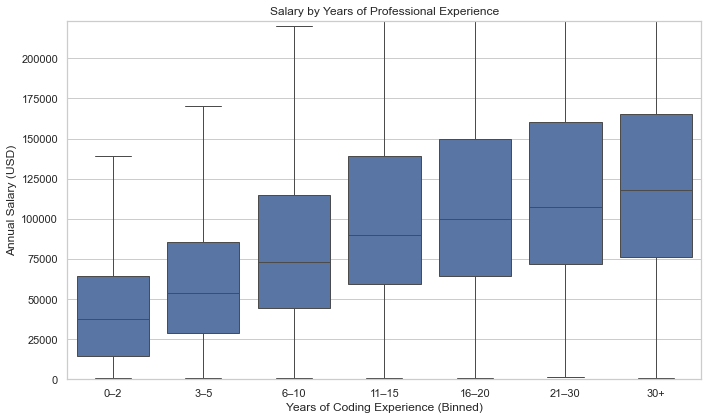

In [84]:
## Salary by years of professional experience
# Filter: Remove missing or unrealistic salary/experience
salary_exp_df = df[
    df['ConvertedCompYearly'].notna() & 
    df['YearsCodePro'].notna()
].copy()

# Bin YearsCodePro for clarity
salary_exp_df['ExperienceBin'] = pd.cut(
    salary_exp_df['YearsCodePro'],
    bins=[0, 2, 5, 10, 15, 20, 30, 50],
    labels=['0–2', '3–5', '6–10', '11–15', '16–20', '21–30', '30+']
)

# Plot
plt.figure(figsize=(10,6))
sns.boxplot(data=salary_exp_df, x='ExperienceBin', y='ConvertedCompYearly', showfliers=False)
plt.title('Salary by Years of Professional Experience')
plt.xlabel('Years of Coding Experience (Binned)')
plt.ylabel('Annual Salary (USD)')
plt.ylim(0, salary_exp_df['ConvertedCompYearly'].quantile(0.95))  # Remove extreme outliers
plt.tight_layout()
plt.show()


The graph shows a clear positive correlation between years of professional experience and annual salary. 
As experience increases, salaries tend to rise steadily.



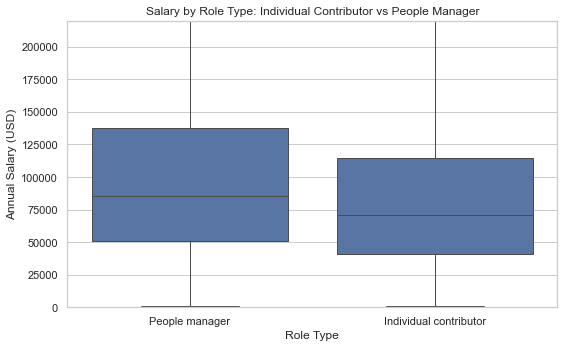

In [85]:
## Salary by ICorPM (Individual Contributor vs People Manager)
# Filter to remove missing or "Missing" values
ic_pm_df = df[
    df['ConvertedCompYearly'].notna() &
    df['ICorPM'].notna() &
    (df['ICorPM'] != 'Missing')
].copy()

# Plot salary distribution by ICorPM
plt.figure(figsize=(8,5))
sns.boxplot(
    data=ic_pm_df,
    x='ICorPM',
    y='ConvertedCompYearly',
    showfliers=False  # hides extreme outliers
)

plt.title('Salary by Role Type: Individual Contributor vs People Manager')
plt.xlabel('Role Type')
plt.ylabel('Annual Salary (USD)')
plt.ylim(0, ic_pm_df['ConvertedCompYearly'].quantile(0.95))  # limit y-axis to 95th percentile
plt.tight_layout()
plt.show()


The average annual salary for a People Manager role is significantly higher than the average salary for an Individual Contributor role. The graph shows a clear gap between the two.

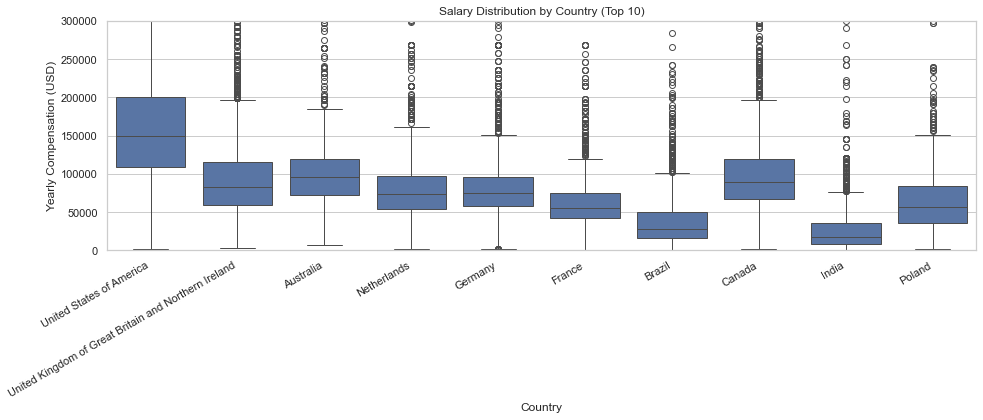

In [86]:
# Salary distribution by country (Top 10)
# Get top 10 countries by frequency
top_countries = df['Country'].value_counts().head(10).index

plt.figure(figsize=(14,6))
sns.boxplot(
    data=df[df['Country'].isin(top_countries)],
    x='Country',
    y='ConvertedCompYearly'
)

plt.xticks(rotation=30, ha='right')
plt.ylim(0, 300000) 
plt.title("Salary Distribution by Country (Top 10)")
plt.xlabel("Country")
plt.ylabel("Yearly Compensation (USD)")
plt.tight_layout()
plt.show()




The graph illustrates significant differences in the salary ranges between the top 10 countries. Some countries like the United States and Canada have a much wider salary distribution, while others like Poland and India have a more compressed range.

Sub-Saharan Median Salary (USD): 24000.0


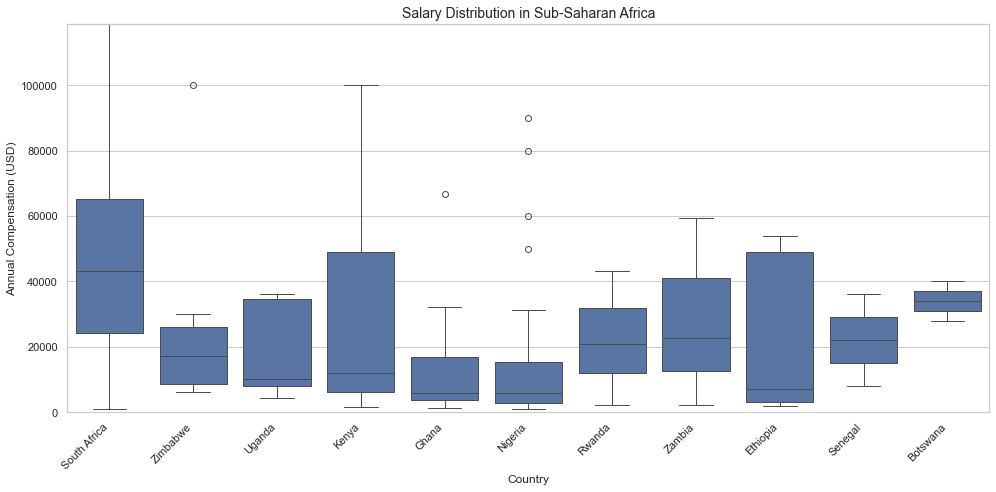

In [87]:
# Sub-Saharan Africa Salary Distribution Boxplot
ssa_countries = [
    'Kenya', 'Nigeria', 'South Africa', 'Ghana', 'Uganda', 'Tanzania', 'Ethiopia',
    'Rwanda', 'Senegal', 'Zambia', 'Zimbabwe', 'Botswana'
]

# Filter data
ssa_df = df_ai[
    df_ai['Country'].isin(ssa_countries) &
    df_ai['ConvertedCompYearly'].notna() &
    df_ai['AIThreat'].isin(valid_ai_responses)
]

# Print summary
print("Sub-Saharan Median Salary (USD):", ssa_df['ConvertedCompYearly'].median())

# Boxplot
plt.figure(figsize=(14, 7))  # Increased width
sns.boxplot(data=ssa_df, x='Country', y='ConvertedCompYearly')
plt.title('Salary Distribution in Sub-Saharan Africa', fontsize=14)
plt.ylabel('Annual Compensation (USD)')
plt.xlabel('Country')
plt.xticks(rotation=45, ha='right')  # Better label alignment
plt.ylim(0, ssa_df['ConvertedCompYearly'].quantile(0.95))  # Remove extreme outliers for visibility
plt.tight_layout()
plt.show()


South Africa has the highest annual compensation levels, with the top end reaching around $80,000.

Countries like Zimbabwe, Uganda, Kenya, and Ghana have salary distributions in the $30,000 to $50,000 range.

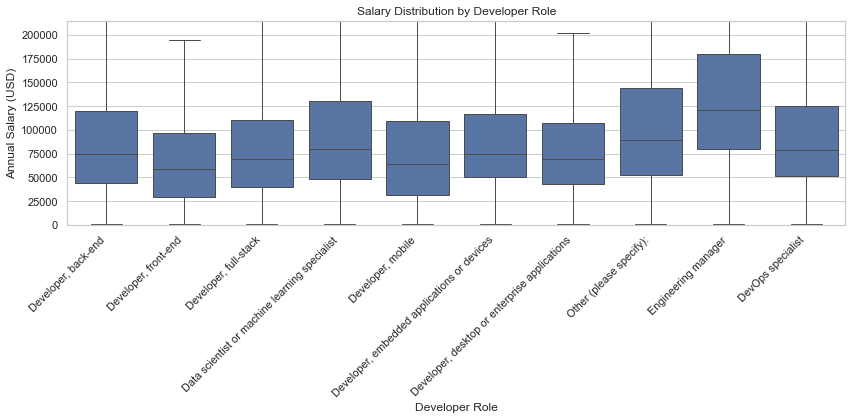

In [88]:
## Salary Distribution by Developer Role (DevType)
# Filter: keep rows with salary and DevType info
role_df = df[
    df['ConvertedCompYearly'].notna() &
    df['DevType'].notna() &
    (df['DevType'] != 'Missing')
].copy()

# Optional: Limit to top 10 most common roles to make the plot readable
top_roles = role_df['DevType'].value_counts().nlargest(10).index
role_df = role_df[role_df['DevType'].isin(top_roles)]

# Plot
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=role_df,
    x='DevType',
    y='ConvertedCompYearly',
    showfliers=False
)

plt.title('Salary Distribution by Developer Role')
plt.xlabel('Developer Role')
plt.ylabel('Annual Salary (USD)')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, role_df['ConvertedCompYearly'].quantile(0.95))  # Clip top 5% to reduce skew
plt.tight_layout()
plt.show()



The roles with the highest salary ranges are Engineering Manager, DevOps Specialist, and Other (please specify). These roles seem to have the potential for the highest annual compensation, reaching up to around $175,000 or more.

### AIThreat vs Selected Features

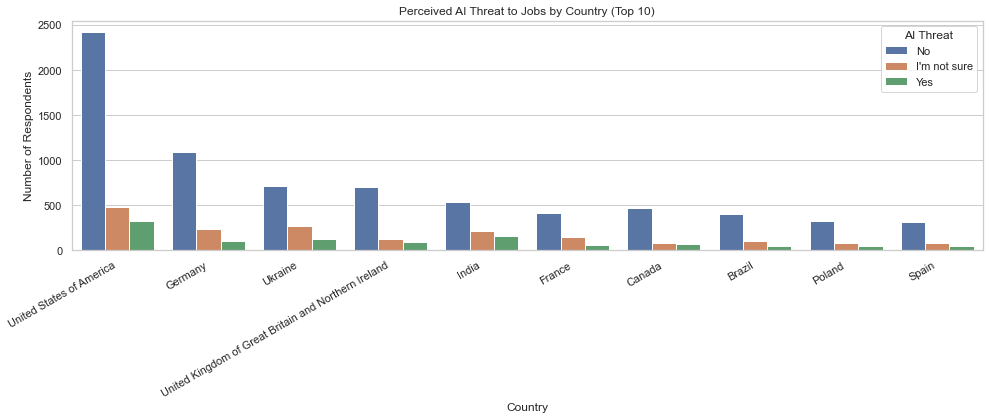

In [89]:
# Perceived AI Threat to Jobs by Country 
# Set seaborn style
sns.set(style="whitegrid")

# Filter for clean AIThreat responses
valid_ai_responses = ["Yes", "No", "I'm not sure"]
df_ai = df[df['AIThreat'].isin(valid_ai_responses)]

# Top 10 countries by count
top_countries = df_ai['Country'].value_counts().nlargest(10).index

# Plot
plt.figure(figsize=(14,6))
ax = sns.countplot(
    data=df_ai[df_ai['Country'].isin(top_countries)],
    x='Country',
    hue='AIThreat',
    order=top_countries  # Ensure order is preserved
)

# Improve alignment
plt.title("Perceived AI Threat to Jobs by Country (Top 10)")
plt.xlabel("Country")
plt.ylabel("Number of Respondents")
plt.xticks(rotation=30, ha='right')  # Rotate and align right
plt.legend(title="AI Threat")
plt.tight_layout()
plt.show()

The United States of America has the highest number of respondents who perceive AI as a threat to jobs, with over 2,000 respondents indicating "No" to the AI threat.
Germany and Ukraine also have a significant number of respondents who do not perceive AI as a threat to jobs.

## Preprocessing for Modeling 

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
# Define target
y = df['ConvertedCompYearly']
X = df.drop(columns='ConvertedCompYearly')

# Identify features
num_feats = ['YearsCodePro']
cat_feats = [col for col in X.columns if col not in num_feats]

# Preprocessor
preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), num_feats),
    
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ]), cat_feats)
])


## Model Training and Evaluation

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Create pipeline
model = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: ${mae:.2f}")
print(f"R² Score: {r2:.3f}")


## Feature Importance

In [ ]:
# Access trained model and get importances
rf_model = model.named_steps['regressor']
ohe = model.named_steps['preprocessing'].named_transformers_['cat'].named_steps['encoder']
feature_names = ohe.get_feature_names_out(cat_feats).tolist() + num_feats

importances = rf_model.feature_importances_
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Plot top 15
plt.figure(figsize=(10,6))
sns.barplot(data=importance_df.head(15), x='importance', y='feature')
plt.title("Top Feature Importances")
plt.tight_layout()
plt.show()


## 🧠 SHAP Explainability + Localized Insights

In [ ]:
# 🧪 Train Final Model
from xgboost import XGBRegressor

# Features and target
X = combined[selected_features]
y = combined['ConvertedCompYearly']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [ ]:
# Pipeline for numeric + categorical handling
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('xgb', XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
])

model.fit(X_train, y_train)



In [ ]:
# SHAP: Global Explainability
import shap
explainer = shap.Explainer(model.named_steps['xgb'])
# Transform the features before SHAP (post-pipeline)
X_transformed = model.named_steps['preprocess'].transform(X_test)
shap_values = explainer(X_transformed)

# SHAP summary plot
shap.summary_plot(shap_values, X_transformed, feature_names=preprocessor.get_feature_names_out())


In [10]:
# Number of responses from Kenya in 2023
kenya_2023 = df_2023[df_2023['Country'] == 'Kenya']
print("2023 Kenya responses:", kenya_2023.shape[0])

# Number of responses from Kenya in 2024
kenya_2024 = df_2024[df_2024['Country'] == 'Kenya']
print("2024 Kenya responses:", kenya_2024.shape[0])

# Number of responses from Africa's Big 3 countries in 2023
big_3_countries = ['Kenya', 'Nigeria', 'South Africa']
big_3_2023 = df_2023[df_2023['Country'].isin(big_3_countries)]
print("2023 Big 3 responses:", big_3_2023.shape[0])

# Number of responses from Africa's Big 3 countries in 2024
big_3_2024 = df_2024[df_2024['Country'].isin(big_3_countries)]
print("2024 Big 3 responses:", big_3_2024.shape[0])

2023 Kenya responses: 244
2024 Kenya responses: 180
2023 Big 3 responses: 1264
2024 Big 3 responses: 843


In [26]:
# Unique countries in df_2023
countries_2023 = df_2023['Country'].dropna().unique()
print("2023 Countries:")
print(sorted(countries_2023))

# Unique countries in df_2024
countries_2024 = df_2024['Country'].dropna().unique()
print("\n2024 Countries:")
print(sorted(countries_2024))


2023 Countries:
['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde', 'Central African Republic', 'Chile', 'China', 'Colombia', 'Congo, Republic of the...', 'Costa Rica', 'Croatia', 'Cuba', 'Cyprus', 'Czech Republic', "Côte d'Ivoire", "Democratic People's Republic of Korea", 'Democratic Republic of the Congo', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Estonia', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Grenada', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'Hong Kong (S.A.R.)', 'Hungary', 'Iceland', 'India', 'In

In [11]:
sub_saharan_africa = [
    'Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi', 'Cape Verde', 'Cameroon',
    'Central African Republic', 'Chad', 'Comoros', 'Democratic Republic of the Congo', 'Congo',
    'Côte d’Ivoire', 'Djibouti', 'Equatorial Guinea', 'Eritrea', 'Eswatini', 'Ethiopia', 
    'Gabon', 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Kenya', 'Lesotho', 'Liberia',
    'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mauritius', 'Mozambique', 'Namibia',
    'Niger', 'Nigeria', 'Rwanda', 'São Tomé and Príncipe', 'Senegal', 'Seychelles', 
    'Sierra Leone', 'Somalia', 'South Africa', 'South Sudan', 'Sudan', 'Tanzania', 
    'Togo', 'Uganda', 'Zambia', 'Zimbabwe'
]

# For 2023
ssa_2023 = df_2023[df_2023['Country'].isin(sub_saharan_africa)]
print("Sub-Saharan Africa responses in 2023:", ssa_2023.shape[0])

# For 2024
ssa_2024 = df_2024[df_2024['Country'].isin(sub_saharan_africa)]
print("Sub-Saharan Africa responses in 2024:", ssa_2024.shape[0])


Sub-Saharan Africa responses in 2023: 1828
Sub-Saharan Africa responses in 2024: 1271


### NOTE TO SELF
columns: Age, Country, EdLevel, LearnCode, LearnCodeCoursesCert, YearsCode, YearsCodePro, WorkExp, Employment, DevType, RemoteWork, OrgSize, ICorPM

include EDA of 2024 for AI replacement

In [12]:
# TBD - possible selected featues
selected_features = [
    'Age', (does not need to be that relevant but we can visualise)
    'Country',
    'Employment',
    'RemoteWork',
    'OrgSize',
    'ICorPM',
    'YearsCodePro',  # or YearsCode/WorkExp
    'DevType',
    'EdLevel',
    'Industry',
    'PurchaseInfluence',
    'BuyNewTool',
    'LanguageHaveWorkedWith',  # Process into top #
    'PlatformHaveWorkedWith',  # Process into top #
    'ToolsTechHaveWorkedWith', # Process into top #
    'ConvertedCompYearly'  # Target variable
]

SyntaxError: invalid syntax (<ipython-input-12-d4224ab80fb1>, line 3)